<a href="https://colab.research.google.com/github/DEli-26/DS_Practicum/blob/main/10_matrix/deli_proj_pract_10_matrix_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6><b>**Я.Практикум. Проект №10**</b></font>
    
<font size=6><b>**Защита персональных данных клиентов**</b></font>

***

# Постановка задачи
**Заказчик:**  
Страховая компания «Хоть потоп».

**Цель:**  
Защитить данные клиентов, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

**Задачи:** 
1. Получить и проанализировать данные;
1. Разработать метод преобразования данных, усложняющий восстановление персональной информации;
1. Обосновать корректность метода.

**Исходные данные:**  
Датафрейм с персональной информацией клиентов.
Признаки: пол, возраст и зарплата застрахованного, количество членов его семьи.
Целевой признак: количество страховых выплат клиенту за последние 5 лет.

# Подготовка окружения

Загрузим библиотеки, необходимые для выполнения проекта

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Темная тема графиков
plt.style.use('dark_background')

Загрузим сами данные.

In [2]:
! gdown XXX

Downloading...
From: https://drive.google.com/uc?id=XXX
To: /content/insurance.csv
100% 95.7k/95.7k [00:00<00:00, 59.1MB/s]


In [3]:
df = pd.read_csv("/content/insurance.csv")

# Exploratory Data Analysis

Вызовем первые 5 строк, общую информацию о таблице.

In [4]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Загруженный датафрейм содержит 5000 объектов с персональной информацией клиентов и содержит следующие проблемы:  
- признаки называются Кириллицей;
- тип хранения данных в столбцах `Возраст` и `Зарплата` может быть заменен на `int` без потери точности модели машинного обучения, но для уменьшения времени ее работы.

Согласно заданию, признаки следующие: пол, возраст и зарплата застрахованного, количество членов его семьи, а целевой признак -  количество страховых выплат.
Определим указанные признаки в соответствующие переменные и переименуем их для дальнейшего удобства работы.
А также исправим тип хранения данных.

In [6]:
X = ['gender', 'age', 'income', 'family_size']
y = ['ins_payments']

df.columns = X + y

df['age'] = df['age'].astype('int')
df['income'] = df['income'].astype('int')

df.head()

,gender,age,income,family_size,ins_payments
0,1,41,49600,1,0
1,0,46,38000,1,1
2,0,29,21000,0,0
3,0,21,41700,2,0
4,1,28,26100,0,0


Проверим количество дубликатов в таблице.

In [7]:
df.duplicated().sum() / len(df)

0.0306

Полученное значение не превосходит 3%. 
Удалим дубликаты соответсвующей функцией.

In [8]:
df = df.drop_duplicates().reset_index(drop=True)

Проанализируем распределение признаков, построив гистограммы.

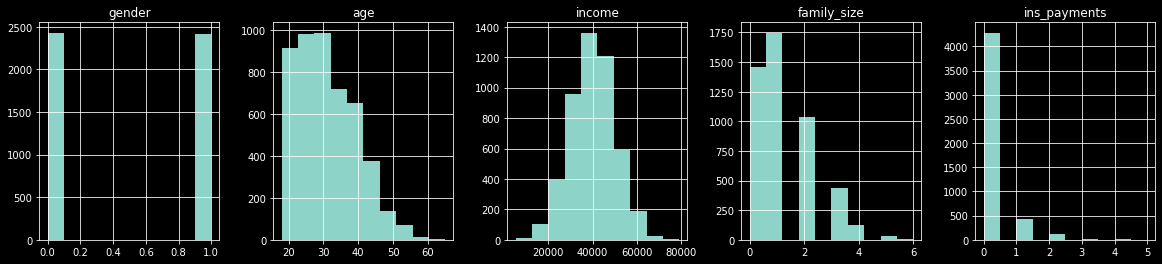

In [9]:
df.hist(layout=(1, 5), figsize=(20, 4), bins=10)
plt.show()

По полученным графикам видно следующее:
- распределение пользователей по половому признаку примерно одинаковое;
- распределение возраста пользователей относится к Пуассоновому типу и не содержит аномально больших выбросов;
- доход пользователей "имеет" нормальное распределение со средним значением около 40 000 у.е., а в рассматриваемой выборке отсутствуют выбросы;
- распределение размера семьи так же не содержит аномальных значений;
- распределение целевого признака показывает наличие существенного дисбаланса классов с существенным "перевесом" нулевых значений.  
Последнее должно учитываться с учетом потребностей заказчика при разработке модели машинного обучения и выборе метрик ее качества, что выходит за рамки настоящего проекта.

# Умножение матриц

По условиям задачи требуется ответить на вопрос:

*Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?*

Для ответа на него рассмотрим, как связаны параметры линейной регрессии в исходной задаче и в преобразованной.
Так, предсказания находятся из формулы:

$$
a = Xw,
$$
где $a$ - вектор предсказаний, $X$ - матрица признаков с нулевым столбцом, отвечающим за смещение нуля, $w$ - вектор весов модели.  

В этом случае задача обучения модели линейной регрессии сводится к нахождению такого вектора $w$, для которого средняя квадратичная ошибка $MSE$ между предсказаниями и целевыми признаками обучающей выборки $y$ имеет наименьшее значение:

$$
w = \arg\min_w MSE(Xw, y).      (1)
$$

Не сложно показать, что условие (1) достигается при выполнении следующего равенства:

$$
w = (X^T X)^{-1} X^T y.       (2)
$$

В случае, если признаки $Х$ умножить на обратимую матрицу $P$, равенство (2) примет вид:

$$
w_{P} = ((X P)^T X P)^{-1} (X P)^T y;
$$
$$
w_{P} = (P^T X^T X P)^{-1} P^T X^T y;
$$
$$
w_{P} = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y. (3)
$$

Учитывая, что $(P^T)^{-1} P^T = E$ и подставляя (2) в (3) получим:

$$
w_{P} = P^{-1} w
$$

Согласно приведенному выражению, умножение признаков на матрицу $P$ приведет к соответствующему умножению вектора весов на обратную матрицу $(P)^{-1}$.
При этом, такое преобразование не влияет на метрику линейной регрессии поумлочанию - среднюю квадратичную ошибку, так как в этом случае она вычисляется согласно выражению:

$$
MSE(X P (P)^{-1}w, y) = MSE(X w, y).
$$

# Алгоритм преобразования

В качестве алгоритма преобразования используем умножение на квадратную обратимую матрицу, элементы которой случайные.

In [10]:
mux_rnd = np.random.default_rng(26).random((len(X), len(X)))
test = np.linalg.inv(mux_rnd)

Ошибки нет, значит матрица обратима.

Произведем умножение признаков и обучение модели линейной регрессии для оригинальных значений и модифицированных.
В качестве метрики качества используем коэффициент детерминации R2, который является вариацией средней квадратичной ошибки.

In [11]:
def fit_r2(X):
    model.fit(X, df[y])
    t = model.predict(X)
    return r2_score(df[y], t)

In [12]:
X_muxed = df[X] @ mux_rnd

model = LinearRegression()

fit_r2(df[X]), fit_r2(X_muxed)

(0.4302010046633359, 0.43020100466332534)

Полученные значения коэффициентов совпадают с точностью менее 0,01%, что обуславливается аппаратными ограничениями вычислительных методов, а не снижением качества обучения модели линейной регрессии.  

# Заключение
Проведен анализ датафрейма с персональной информацией клиентов компании «Хоть потоп».
В результате анализа исправлены наименования столбцов, типы хранения данных и удалены дубликаты.
Кроме того, показан существенный дисбаланса классов с "перевесом" нулевых значений целевого признака, что должно учитываться с учетом потребностей заказчика при разработке модели машинного обучения.

Аналитически показано отсутсвие влияния умножения матрицы с признаками на обратимую матрицу на метрику линейной регрессии - среднюю квадратичную ошибку.
На основе указанного доказательства предложен метод преобразования данных в виде умножения на квадратную обратимую матрицу, элементы которой случайные.
Корректность метода подтверждена моделированием, результаты которого идентичны для модели с модифицированными значениями признаков и нет.